In [1]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os, glob, subprocess
import scanpy.api as sc
import anndata as ad
from scipy import sparse
from plotnine import *
import plotnine
from IPython.core.display import HTML

def translate(seq, frame=1): 
    # frame: 1 = start at pos 0; 2 = start at pos 1; 3 = start at pos 2
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'', 'TAG':'', 
        'TGC':'C', 'TGT':'C', 'TGA':'', 'TGG':'W', 
    } 
    comp_dict = {'C':'G',
                 'G':'C',
                 'A':'T',
                 'T':'A'
                }
    protein = ''
    
    if frame == 1 :
        start_val = 0
    if frame == 2:
        start_val = 1
    if frame == 3:
        start_val = 2
    if frame == 4 :
        start_val = 0
    if frame == 5:
        start_val = 1
    if frame == 6:
        start_val = 2
    if frame > 3:
        seq = ''.join([comp_dict.get(x) for x in seq])
        
    for i in range(start_val, len(seq), 3): 
        try:
            codon = seq[i:i + 3] 
            protein+= table[codon] 
        except:
            break
    return protein


def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# filter completed samples
def find_completed (results_dir, dir_path, target_suffix):
    fa_list = []
    blastOut_list = []

    # check for completed files: *_geneCounts.csv
    for outfile in glob.glob(f'{results_dir}*/*_geneCounts.csv'):
        with open(outfile, 'r') as out_f:
            deduce_cell_id = outfile.split('/')[-2]
        deduce_target = f'{dir_path}{deduce_cell_id}{target_suffix}'
        deduce_out = f'{results_dir}{deduce_cell_id}/{deduce_cell_id}_blastpOut.txt'
        fa_list = fa_list + [deduce_target]
        blastOut_list = blastOut_list + [deduce_out]
    return fa_list, blastOut_list

def process_blastp_results(target_output, results_dir, evalue_cutoff):
    # ingest table
    results = pd.read_csv(target_output, 
                          sep = '\t',
                          header = None
                         )
    results.columns = ['qsid' , 'ssid', 'evalue']
    # parse frame and ids
    results['frame'] = [x.split('__')[-1][-1] for x in results['qsid']]
    results['qsid'] = [x.split('__')[0] for x in results['qsid']]
    results['uniprot'] = [x.split('|')[1] for x in results['ssid']]
    results['common_name'] = [x.split('|')[2] for x in results['ssid']]
    # return best-match frame
    results = results.sort_values('evalue', ascending = True).groupby(['qsid']).head(1)
    # filter results to significant matches
    results = results[results.evalue < evalue_cutoff]
    # adjust df to merge
    results = (results
               .loc[:,['uniprot','qsid']]
               .rename(columns = {'qsid':'seq_id'})
              )

    # ingest uniprot to symbol df for lookup
    scope2field_df = pd.read_csv(f'{results_dir}scope2field.csv',index_col = 0)
    results = pd.merge(scope2field_df,
                       results,
                       'inner',
                       'uniprot'
                      )
    results = results.drop('uniprot', axis = 1)
               
    return results

def run_blastp(input_fn, prot_ref, n_threads, ouput_fn, log_fn):
    # run blast
    blast_cmd_list = ['blastp',
                      '-query',
                      input_fn,
                      '-db',
                      prot_ref,
                      '-task',
                      'blastp-fast',
                      '-matrix',
                      'BLOSUM45',
                      '-evalue',
                      '1000',
                      '-outfmt',
                      '"6 evalue qseqid sseqid"',
#                       '-num_descriptions',
#                       '1',
#                       '-num_alignments',
#                       '1',
                      '-max_target_seqs',
                      '5',
                      '-num_threads',
                      f'{n_threads}',
                      '-out',
                      ouput_fn,
                     ]
    blast_cmd = ' '.join(blast_cmd_list)
    print(blast_cmd)
    subprocess.call(blast_cmd, shell=True)
    with open(log_fn, 'a') as outf:
        outf.write(f'{input_fn}\n')

/home/daniel_le/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
# identify input data
input_dir = '/home/daniel_le/data/longreads/trimmed_tests/'
fa_list = glob.glob(f'{input_dir}*.fa')
entry_len_list = []
for fn in fa_list:
    entry_len_list = entry_len_list+[int(file_len(fn)/2)]
balanced_entry_len_sum = np.sum(entry_len_list).astype(int)


In [3]:
# kmerize
ksize = 8
nkmers = 4**ksize

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, balanced_entry_len_sum))

arr_idx = 0
seq_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')
cell_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')

# ingest all .fa files from dir
for fn in fa_list:
    # extract fn prefix for cell id
    cell_id = fn.split('/')[-1].split('.fa')[0]

    with open(fn, 'r') as f:

        # parse entry by entry
        for count, line in tqdm.tqdm(enumerate(f, start=0)):   

            # extract first line as seq id
            if count % 2 == 0:
                k_name = line[1:-1]

            # extract second line as sequence
            if count % 2 != 0:

                # Initialize countgraph
                tablesize = nkmers + 10
                ktable = khmer.Countgraph(ksize, tablesize, 1)

                # count all k-mers in the given string
                ktable.consume(line[:-1])

                # capture full kmer counts
                k_n_list = [ktable.get(i) for i in range(nkmers)]

                # update kmer count arr
                kmer_arr[:,arr_idx] = k_n_list 

                # log sequence and cell names for metadata
                seq_id_arr[arr_idx] = k_name
                cell_id_arr[arr_idx] = cell_id

                # update arr pointer
                arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
master_df = master_df.astype(int)
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


400it [00:03, 125.92it/s]
400it [00:02, 135.58it/s]
400it [00:03, 131.16it/s]
400it [00:03, 131.90it/s]
400it [00:02, 138.09it/s]
400it [00:02, 133.93it/s]
400it [00:03, 129.11it/s]
400it [00:03, 133.19it/s]
400it [00:03, 132.59it/s]
400it [00:03, 130.26it/s]
400it [00:03, 131.37it/s]
400it [00:03, 131.41it/s]
400it [00:03, 131.26it/s]
400it [00:03, 131.16it/s]
400it [00:02, 168.01it/s]
400it [00:02, 140.79it/s]
400it [00:02, 134.80it/s]
400it [00:02, 133.78it/s]
400it [00:02, 153.04it/s]
400it [00:02, 165.87it/s]
400it [00:02, 163.38it/s]
400it [00:02, 181.60it/s]
400it [00:02, 139.12it/s]
400it [00:03, 131.79it/s]
400it [00:03, 129.12it/s]
400it [00:03, 129.36it/s]
400it [00:03, 128.61it/s]
400it [00:03, 129.02it/s]
400it [00:03, 130.17it/s]
390it [00:03, 129.47it/s]
400it [00:03, 129.71it/s]
400it [00:03, 129.02it/s]
400it [00:03, 130.01it/s]
400it [00:03, 131.34it/s]
400it [00:03, 131.30it/s]
400it [00:03, 130.44it/s]
400it [00:03, 130.89it/s]
400it [00:03, 129.64it/s]
400it [00:02

In [4]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

/home/daniel_le/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


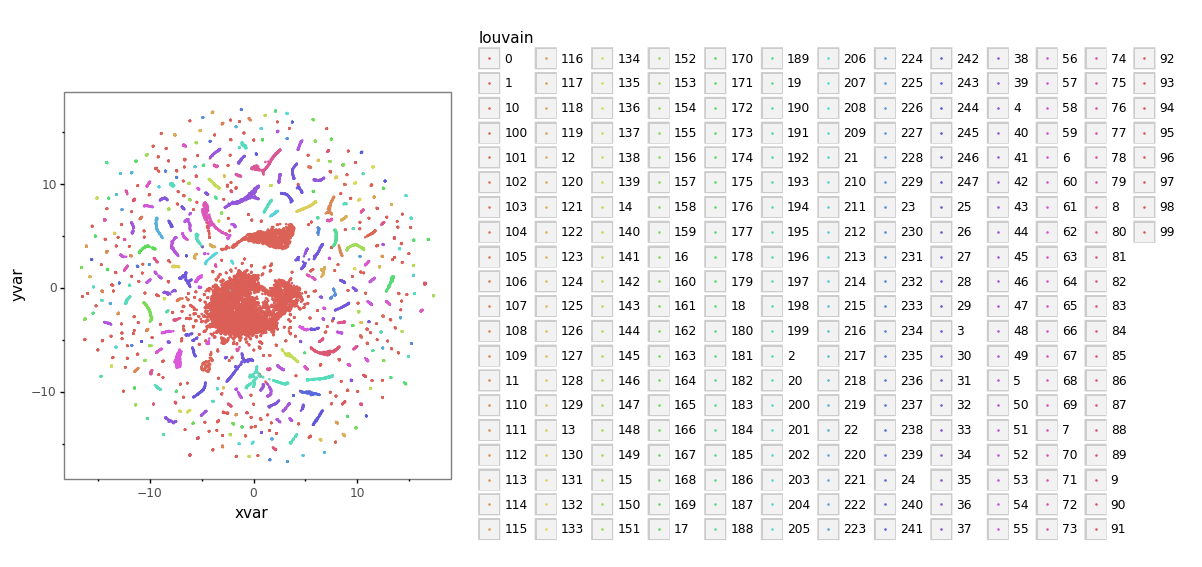

<ggplot: (8739834978693)>


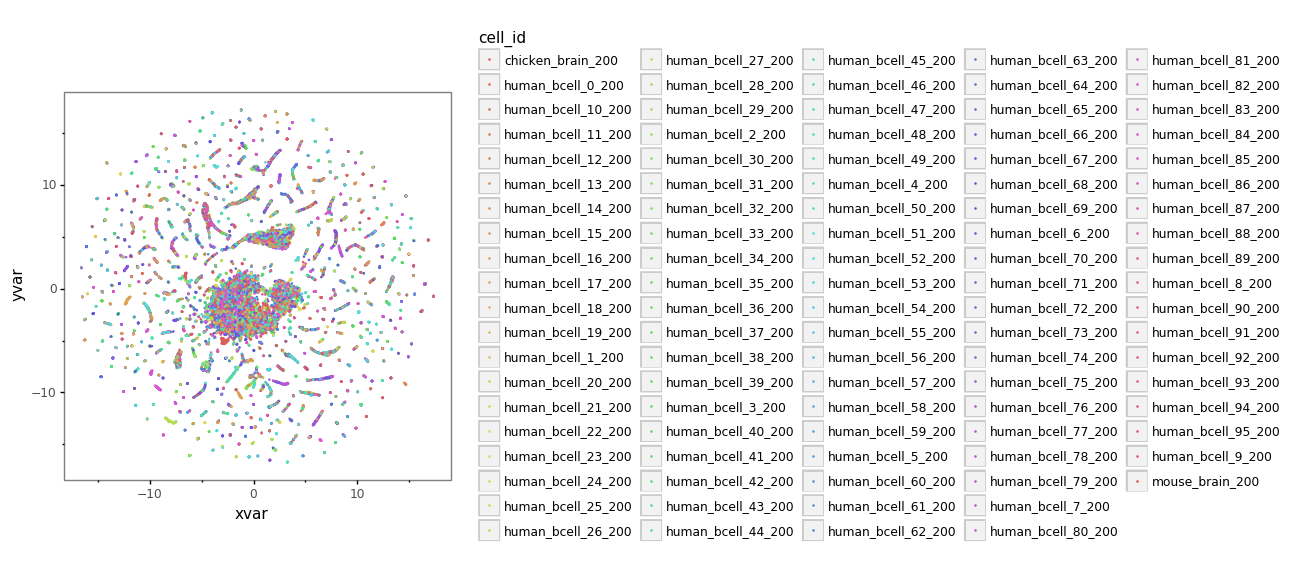

<ggplot: (8740591308277)>


In [13]:
# embed and cluster
n_pcs = 200
n_neighbs = 10
min_dist = 0.3
louvain_res = 0.1

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata,svd_solver='arpack',use_highly_variable = False,n_comps=n_pcs,random_state=100) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=100) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=100, init_pos='random')
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=100)

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
umap_df['seq_id'] = all_forms_adata.obs.index.tolist()
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()

plotnine.options.figure_size = (5,5)
for val in ['louvain','cell_id']:
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=val), 
                         size=0.05)

           )
    print(plot)

In [14]:
sample_n = 10
out_dir = f'{input_dir}outputs/'
clear_files = True

if clear_files == True:
    for x in glob.glob(f'{out_dir}*.fa'):
        os.remove(x)

outfile = f'{out_dir}allClusters.fa'
cluster_count_df = pd.DataFrame()
for cluster_oi in list(set(all_forms_adata.obs.louvain)):
    cluster_slice = all_forms_adata[all_forms_adata.obs.louvain == cluster_oi]
    fn_oi = cluster_slice.obs.cell_id.tolist()[:sample_n]
    entry_oi = cluster_slice.obs.index.tolist()[:sample_n]
    cluster_count_df = cluster_count_df.append(pd.DataFrame({'cluster':[cluster_oi],'entry_n':len(entry_oi)}))
    for fn, entry, fn_prefix in zip([f'{input_dir}{x}.fa' for x in fn_oi],
                         entry_oi,
                         fn_oi
                        ):

        with open(fn, 'r') as f:

            # parse entry by entry
            for count, line in enumerate(f, start=0):   

                # extract first line as seq id
                if count % 2 == 0:
                    k_name = line[1:-1].split(' ')[0]

                # extract second line as sequence
                if count % 2 != 0 and k_name == entry.split(' ')[0]:
                    for frame in [1,2,3,4,5,6]:
                        seq = translate(line[:-1],frame)
                        with open(outfile, 'a') as outf:
                            outf.write(f'>{k_name}_fr_{frame}_cl_{cluster_oi}_fn_{fn_prefix}\n{seq}\n')

In [ ]:
prot_ref = '/home/daniel_le/data/longreads/proteome/UP000005640_9606.fasta'
n_threads = 32
log_fn = f'{out_dir}blast_results/log.txt'
clear_files = True

if clear_files == True:
    for x in glob.glob(f'{out_dir}blast_results/*'):
        os.remove(x)

for blast_targets in glob.glob(f'{out_dir}*.fa'):
    prefix = blast_targets.split('/')[-1].split('.')[0]
    ouput_fn = f'{out_dir}blast_results/{prefix}_blast.tsv'
    run_blastp(blast_targets, prot_ref, n_threads, ouput_fn, log_fn)

blastp -query /home/daniel_le/data/longreads/trimmed_tests/outputs/allClusters.fa -db /home/daniel_le/data/longreads/proteome/UP000005640_9606.fasta -task blastp-fast -matrix BLOSUM45 -evalue 1000 -outfmt "6 evalue qseqid sseqid" -max_target_seqs 5 -num_threads 32 -out /home/daniel_le/data/longreads/trimmed_tests/outputs/blast_results/allClusters_blast.tsv


In [17]:
# ingest blast results and score entries
subject_n = 1
blast_result = pd.read_csv(ouput_fn, sep = '\t', header=None)
blast_result.columns = ['evalue','qsid_fr_cl_fn','ssid']
# machine precision estimate: ref = https://www.biostars.org/p/43484/
blast_result = blast_result.replace(0, 2.225074e-308)
blast_result['qsid'] = [x.split('_fr_')[0] for x in blast_result['qsid_fr_cl_fn']]
blast_result['frame'] = [x.split('_fr_')[1].split('_cl_')[0] for x in blast_result['qsid_fr_cl_fn']]
blast_result['cluster'] = [x.split('_cl_')[1].split('_fn_')[0] for x in blast_result['qsid_fr_cl_fn']]
blast_result['fsource'] = [x.split('_fn_')[1] for x in blast_result['qsid_fr_cl_fn']]
blast_result['log_evalue'] = -np.log10(blast_result['evalue'])
# return best match for each subject, with respect to cluster and read
blast_max_result = (pd.DataFrame(blast_result.groupby(['cluster',
                                                   'qsid',
                                                   'ssid'])['log_evalue'].max())
                .reset_index()
               )
# sum subject match scores across reads
blast_score = (pd.DataFrame(blast_max_result.groupby(['cluster','ssid'])['log_evalue'].sum())
                .reset_index()
               )
# normalize to the number of reads blasted
blast_score = pd.merge(blast_score, cluster_count_df, 'left', 'cluster')
blast_score['mean_log_evalue'] = blast_score['log_evalue']/blast_score['entry_n']
blast_score['neg_mean_log_evalue'] = [-x for x in blast_score['mean_log_evalue']]
# subset results
blast_score = (blast_score
                .sort_values('mean_log_evalue', ascending = False)
                .groupby('cluster')
                .head(subject_n)
                .sort_values(['cluster','neg_mean_log_evalue'], ascending = True)
                .drop('neg_mean_log_evalue', axis = 1)
               )

# translate uniprot to gene symbol
scope_df = pd.read_csv('/home/daniel_le/data/longreads/proteome/scope2field.csv', index_col = 0)
scope_df = scope_df.drop_duplicates()
cluster_annotation_df = blast_score.loc[:, ['cluster','entry_n','ssid','mean_log_evalue']]
cluster_annotation_df['uniprot'] = [x.split('|')[1] for x in cluster_annotation_df['ssid']]
cluster_annotation_df = pd.merge(cluster_annotation_df,scope_df,'inner','uniprot')
cluster_annotation_df = cluster_annotation_df.sort_values('mean_log_evalue')


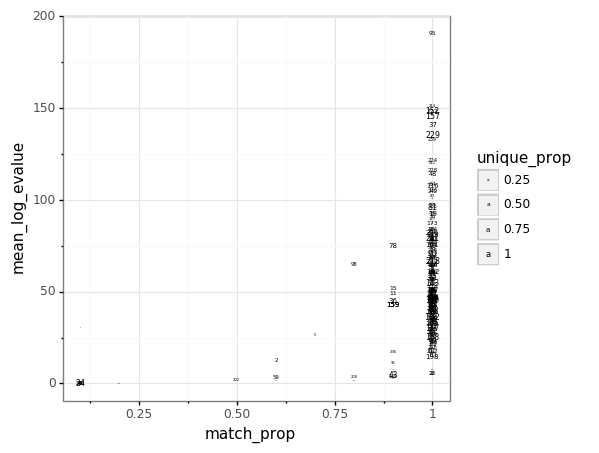

<ggplot: (8740591092833)>


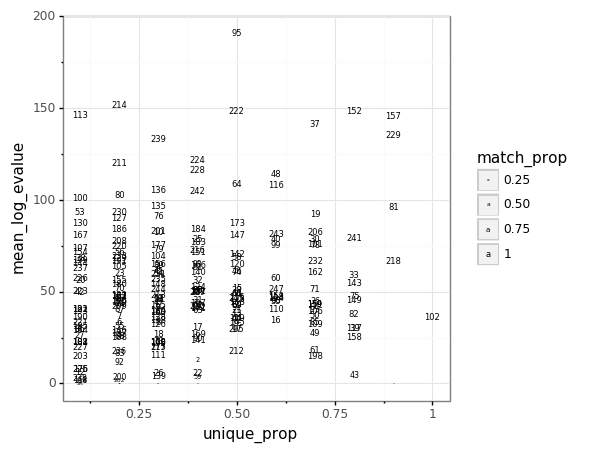

<ggplot: (8740607022729)>


/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


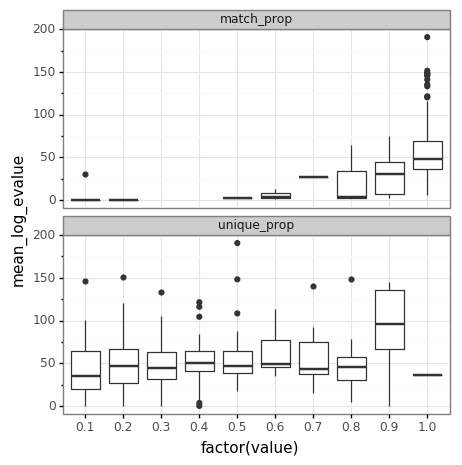

<ggplot: (8740612542413)>


In [18]:
# covariates: match count
covar_df = pd.merge(cluster_annotation_df, 
         pd.DataFrame(blast_result
                      .loc[:,['cluster','ssid','qsid']]
                      .drop_duplicates()
                      .groupby(['cluster'])['ssid']
                      .value_counts()).rename(columns={'ssid':'match_count'}).reset_index(),
         'left',
         ['cluster','ssid']
        ).sort_values(['match_count','mean_log_evalue'], ascending=False)
covar_df['match_prop'] = covar_df['match_count']/covar_df['entry_n']

# covariates: fsource uniqueness
unique_fsource = (pd.DataFrame(pd.merge(blast_max_result.loc[:,['cluster','qsid']].drop_duplicates(), 
                                 blast_result.loc[:,['qsid','fsource']],
                                 'left',
                                 'qsid'
                                )
                         .groupby('cluster')['fsource']
                         .nunique()
                        )
                  .rename(columns={'fsource':'unique_fsource'})
                  .reset_index()
                 )
covar_df = pd.merge(covar_df, unique_fsource, 'left','cluster')
covar_df['unique_prop'] = covar_df['unique_fsource']/covar_df['entry_n']

plot = (ggplot(covar_df)
        + theme_bw()
        + geom_text(aes('match_prop','mean_log_evalue',size='unique_prop',label='cluster'))
       )
print(plot)

plot = (ggplot(covar_df)
        + theme_bw()
        + geom_text(aes('unique_prop','mean_log_evalue',size='match_prop',label='cluster'))
       )
print(plot)

covar_df_melt = pd.melt(covar_df.loc[:,['cluster','mean_log_evalue','match_prop','unique_prop']],
                        id_vars=['cluster','mean_log_evalue']
                       )

plot = (ggplot(covar_df_melt)
        + theme_bw()
        + geom_boxplot(aes('factor(value)','mean_log_evalue'))
        + facet_wrap('~variable', ncol=1)
       )
print(plot)


In [19]:
# ingest data to adata obj
# merge with cell-specific clusters
cell_by_cluster = pd.merge(umap_df.rename(columns = {'louvain':'cluster'}),
                           cluster_annotation_df.loc[:,['cluster','symbol']],
                           'inner',
                           'cluster'
                          )
cell_by_cluster = ((pd.DataFrame(cell_by_cluster
                                 .groupby(['cell_id'])['symbol']
                                 .value_counts()
                                 .rename('count')
                                )
                     .reset_index()
                     .pivot(index='symbol', columns='cell_id', values='count')
                    )
                     .replace(np.nan, 0)
                     .astype(int)
                    )

# pd df to np array
array_adata = cell_by_cluster.values

# extract obs and var
obs = cell_by_cluster.columns.tolist()
gene_names = cell_by_cluster.index.tolist()

# create ad obj
cell_adata = ad.AnnData(X=array_adata).T
cell_adata.X = sparse.csr_matrix(cell_adata.X)
cell_adata.var_names = gene_names
cell_adata.obs_names = obs

# transform and freeze raw state
cell_adata.raw = sc.pp.log1p(cell_adata, copy=True)

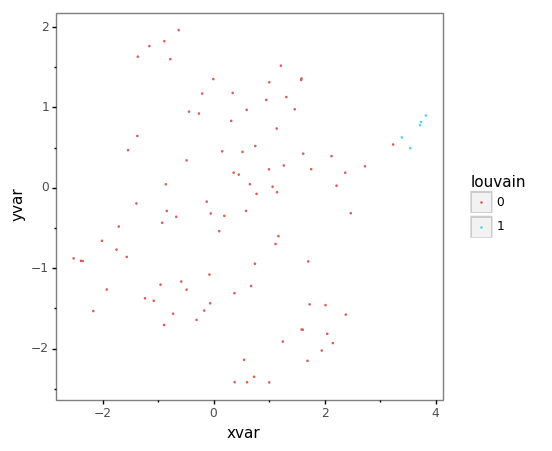

<ggplot: (8740580167293)>


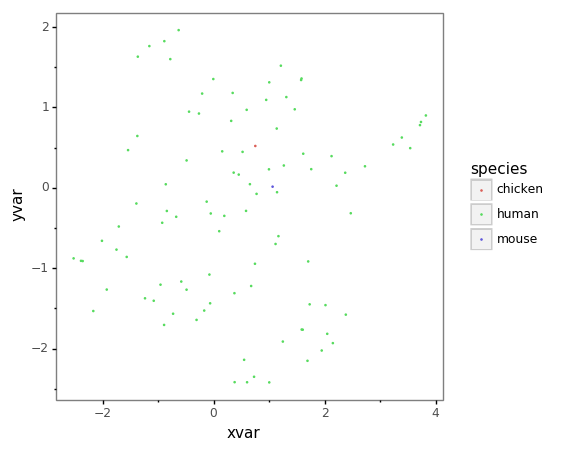

<ggplot: (8739835267217)>


In [20]:
# embed and cluster
n_pcs = 50
n_neighbs = 4
min_dist = 0.1
louvain_res = 0.3

all_cells_adata = sc.pp.log1p(cell_adata, copy=True) 
sc.pp.scale(all_cells_adata) 
sc.tl.pca(all_cells_adata,svd_solver='arpack',use_highly_variable = False,n_comps=n_pcs,random_state=100) 
sc.pp.neighbors(all_cells_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=100) 
sc.tl.umap(all_cells_adata, min_dist = min_dist, random_state=100, init_pos='random')
sc.tl.louvain(all_cells_adata, resolution = louvain_res, random_state=100)

umap_df = pd.DataFrame(all_cells_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_cells_adata.obs.index.tolist()
umap_df['louvain'] = all_cells_adata.obs.louvain.tolist()
umap_df['species'] = [x.split('_')[0] for x in umap_df['cell_id']]

plotnine.options.figure_size = (5,5)
for val in ['louvain','species']:
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=val), 
                         size=0.05)

           )
    print(plot)
